# 1.Imports

In [214]:
import copy

import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns

# Used to draw a progress bar for longer method calls
from tqdm import tqdm

# Used to detect language used in each document
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

# Pre-trained natural language processing pipeline for biomedical use
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

# Used to import list of punctuations
import string

# Feature extraction (text vectorizers)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering and evaluation
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn import metrics
from scipy.spatial.distance import cdist

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

# 2.load dataset

In [2]:
df_10k = pd.read_csv('10k_df.csv')

# 3.preprocesses

In [3]:
df_10k.fillna(value=" ",inplace=True)

In [4]:
df = df_10k.sample(1500, random_state=42)
del df_10k

In [5]:
df.reset_index(drop=True, inplace=True)
df

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,fefd6cdcddcb00d1ba2ef1a0d3bba9f312010a1d,10.1111/j.1524-4733.2008.00379.x,,China is the biggest country in the world that...,"Li, Youing. Sun, Xin. Wang, Li",Evidence-Based Medicine in China,Value in Health,Not provided.
1,2a3d080d5dcf6771db002366691f35e5d6f0e493,10.1007/s13238-010-0029-7,,"✉ Correspondence: zlshi@wh.iov.cn Bat, the onl...","Shi, Zhengli",Bat and virus,Protein & Cell,Not provided.
2,2de657aabab331e75657bfc1443542fd345b6f26,10.1016/j.ccc.2019.06.001,KEYWORDS\nPandemic Influenza Disaster prepared...,Outbreaks of infectious disease pose unique ch...,"Maves, Ryan C.. Jamros, Christina M.. Smith...",Intensive Care Unit Preparedness During<br>Pa...,Crit Care Clin,KEYWORDS\nPandemic Influenza Disaster<br>prep...
3,bc22758234283f024f16e2dbe660bc909b512b92,10.1016/j.vetpar.2007.11.020,Cryptosporidium parvum is recognized as one of...,Diarrhoeal diseases of infectious aethiology r...,"Klein, Pavel. Kleinová, Tereza. Volek,<br>Z...",Effect of Cryptosporidium parvum infection on...,Veterinary Parasitology,Cryptosporidium parvum is recognized as one o...
4,a204aafa38365dbcc0a26af3ca2c6d3313d7fab2,10.1111/irv.12518,", Brazil, in the period of Background: The res...",The inclusion criteria for asymptomatic adults...,"Moreira, Luciana Peniche. Watanabe, Aripuana...",Respiratory syncytial virus evaluation among<...,Influenza Other Respir Viruses,", Brazil, in the period of Background: The<br..."
...,...,...,...,...,...,...,...,...
1495,e021d75c9a2c8f02f80ccfbad4133b15d1777576,10.1038/sj.eye.6701885,Many new infectious diseases in humans have be...,Severe acute respiratory syndrome (SARS) is th...,"Chan, W-M. Liu, D T L. Chan, P K S. Chong,...",Precautions in ophthalmic practice in a<br>ho...,Eye (Lond),Many new infectious diseases in humans have<b...
1496,24beb94c313a07be6b0c745a6ca8a3d810618506,,The Middle East respiratory syndrome coronavir...,The Middle East respiratory syndrome (MERS) is...,"Ozharovskaia, T. A.. Zubkova, O. V.. <br>Dol...",Immunogenicity of Different Forms of Middle<b...,Acta Naturae,The Middle East respiratory syndrome<br>coron...
1497,94475eaa419b11d7edf53c2fe4e423acef0ce881,10.12688/wellcomeopenres.15718.1,The current novel coronavirus outbreak appears...,The ongoing outbreak of novel Coronavirus appe...,"Abbott, Sam. Hellewell, Joel. Munday, James...",The transmissibility of novel Coronavirus in<...,Wellcome Open Res,The current novel coronavirus outbreak<br>app...
1498,a6ab8b27158a48683b4fa6d081614cde9087cc5e,10.1016/j.bja.2020.05.002,,Editor -The critical shortage of medical suppl...,"Lang, Angela L.. Shaw, Kendrick M.. Lozano,...",Effectiveness of a negative-pressure patient<...,Br. j. anaesth,Not provided.


In [6]:
en_counter = 0
for bdy_txt in tqdm(df.body_text):
   res = detect(bdy_txt)
   if res == 'en':
       en_counter += 1
print(("{:.2f}".format((en_counter / len(df.body_text)) * 100)), "of Articles are English")

100%|██████████| 1500/1500 [00:26<00:00, 56.05it/s]

96.93 of Articles are English


In [7]:
for index, bdy_txt in tqdm(enumerate(df.body_text)):
   res = detect(bdy_txt)
   if res != 'en':
       df.drop(index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

1500it [00:26, 57.12it/s]


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,fefd6cdcddcb00d1ba2ef1a0d3bba9f312010a1d,10.1111/j.1524-4733.2008.00379.x,,China is the biggest country in the world that...,"Li, Youing. Sun, Xin. Wang, Li",Evidence-Based Medicine in China,Value in Health,Not provided.
1,2a3d080d5dcf6771db002366691f35e5d6f0e493,10.1007/s13238-010-0029-7,,"✉ Correspondence: zlshi@wh.iov.cn Bat, the onl...","Shi, Zhengli",Bat and virus,Protein & Cell,Not provided.
2,2de657aabab331e75657bfc1443542fd345b6f26,10.1016/j.ccc.2019.06.001,KEYWORDS\nPandemic Influenza Disaster prepared...,Outbreaks of infectious disease pose unique ch...,"Maves, Ryan C.. Jamros, Christina M.. Smith...",Intensive Care Unit Preparedness During<br>Pa...,Crit Care Clin,KEYWORDS\nPandemic Influenza Disaster<br>prep...
3,bc22758234283f024f16e2dbe660bc909b512b92,10.1016/j.vetpar.2007.11.020,Cryptosporidium parvum is recognized as one of...,Diarrhoeal diseases of infectious aethiology r...,"Klein, Pavel. Kleinová, Tereza. Volek,<br>Z...",Effect of Cryptosporidium parvum infection on...,Veterinary Parasitology,Cryptosporidium parvum is recognized as one o...
4,a204aafa38365dbcc0a26af3ca2c6d3313d7fab2,10.1111/irv.12518,", Brazil, in the period of Background: The res...",The inclusion criteria for asymptomatic adults...,"Moreira, Luciana Peniche. Watanabe, Aripuana...",Respiratory syncytial virus evaluation among<...,Influenza Other Respir Viruses,", Brazil, in the period of Background: The<br..."
...,...,...,...,...,...,...,...,...
1449,e021d75c9a2c8f02f80ccfbad4133b15d1777576,10.1038/sj.eye.6701885,Many new infectious diseases in humans have be...,Severe acute respiratory syndrome (SARS) is th...,"Chan, W-M. Liu, D T L. Chan, P K S. Chong,...",Precautions in ophthalmic practice in a<br>ho...,Eye (Lond),Many new infectious diseases in humans have<b...
1450,24beb94c313a07be6b0c745a6ca8a3d810618506,,The Middle East respiratory syndrome coronavir...,The Middle East respiratory syndrome (MERS) is...,"Ozharovskaia, T. A.. Zubkova, O. V.. <br>Dol...",Immunogenicity of Different Forms of Middle<b...,Acta Naturae,The Middle East respiratory syndrome<br>coron...
1451,94475eaa419b11d7edf53c2fe4e423acef0ce881,10.12688/wellcomeopenres.15718.1,The current novel coronavirus outbreak appears...,The ongoing outbreak of novel Coronavirus appe...,"Abbott, Sam. Hellewell, Joel. Munday, James...",The transmissibility of novel Coronavirus in<...,Wellcome Open Res,The current novel coronavirus outbreak<br>app...
1452,a6ab8b27158a48683b4fa6d081614cde9087cc5e,10.1016/j.bja.2020.05.002,,Editor -The critical shortage of medical suppl...,"Lang, Angela L.. Shaw, Kendrick M.. Lozano,...",Effectiveness of a negative-pressure patient<...,Br. j. anaesth,Not provided.


In [8]:
nlp = spacy.load("en_core_sci_lg", disable=["parser", "ner"])
nlp.max_length = 2500000

C:\Users\arian\PycharmProjects\TextMining\venv\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [9]:
from string import punctuation
punctuations = list(punctuation)
print(punctuations)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [10]:
for index, bdy_txt in tqdm(enumerate(df['body_text'])):
    refined_bdy_txt = ''.join([i for i in bdy_txt if not i.isdigit()])
    df.at[index, 'body_text'] = ''.join(refined_bdy_txt)

1454it [00:03, 463.74it/s]


In [11]:
df['body_text'][0]

'China is the biggest country in the world that has . billion population. The health of the population has been one of the issues most relevant to sustainable development of the economy and society. However, limited availability of health services is unable to meet the enormous health needs. The estimated annual incidence of cancers .%, cardiovascular diseases %, infection diseases .% in , whereas only . clinicians, . nurses and . ward beds per thousand are available to provide services in  [] . With the rapid shift of infectious diseases to chronic diseases in the Chinese population, the health spending is increased dramatically. The national health expenditure in  has been tripled to . billion Renminbi (RMB) compared to that in  [] , whereas an increase of national health budget from . billion in  to . billion in  [] cannot cope with the steep climbing of health expenditure. It is a big challenge to utilize the limited health-care capacity to keep all the population healthy.\nOn the 

In [12]:
## adding et al. and cf in Stop Words set
custom_stop_words = copy.deepcopy(STOP_WORDS)
custom_stop_words.update(['et', 'cf', 'al.'])
print(custom_stop_words)

{'yet', 'becoming', "'ll", 'across', 'all', 'via', 'then', 'five', 'empty', 'n‘t', 'in', 'already', 'do', 'bottom', 'whereupon', 'been', 'either', '’m', 'herself', 'hence', "'d", 'else', 'whom', '’re', 'also', '‘m', 'that', 'back', 'elsewhere', 'regarding', 'hers', 'once', 'none', 'forty', 'upon', 'whence', 'between', 'make', 'indeed', 'just', 'thereby', 'besides', 'than', 'hereupon', 'three', 'however', 'though', 'last', 'the', 'whither', 'through', 'thence', 'off', 'this', 'seems', 'next', 'noone', 'alone', 'six', 'sixty', 'go', 'say', 'why', 'where', 'whether', 'other', 'cf', 'himself', 'due', 'never', 'beside', 'except', 'any', 'much', 'should', "'re", "'m", 'front', 'so', 'someone', 'wherein', 'hundred', 'same', 'no', 'ten', 'everyone', 'ever', 'it', 'since', 'beforehand', 'throughout', 'whereby', 'which', 'somehow', 'yours', 'because', 'onto', 'side', 'was', 'above', 'thru', 'per', 'often', 'very', 'after', 'anyhow', 'another', 'without', 'al.', 'our', 'serious', 'yourselves', 'h

In [13]:
for word in custom_stop_words:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [14]:
spacy.prefer_gpu()
for index, bdy_txt in tqdm(enumerate(df.body_text), desc='Tokenizing'):
    doc = nlp(bdy_txt)
    # Extract lemmatized tokens without any stopping words or punctuation
    # lemmatizing
    doc = [ word.lemma_.lower().strip() for word in doc if word.lemma_ != "-PRON-"]

    # removing stop words and Numbers
    doc = [ word for word in doc if word not in custom_stop_words and word not in punctuations]
    # Join the lemmatized tokens into a sentence
    df.at[index, 'processed_body_text'] = ' '.join(doc)


Tokenizing: 1454it [07:34,  3.20it/s]


# just checking tokenizing

In [227]:
vectorizer = TfidfVectorizer(max_features=16)
vectorized_X = vectorizer.fit_transform(df['processed_body_text'].values)
vectorized_X = pd.DataFrame(vectorized_X.toarray())

In [228]:
print(vectorizer.get_feature_names_out())

['case' 'cell' 'disease' 'group' 'high' 'include' 'increase' 'infection'
 'patient' 'protein' 'result' 'study' 'time' 'use' 'viral' 'virus']


In [229]:
pca = PCA(0.95)
pca_X = pca.fit_transform(vectorized_X)
pca_X = pd.DataFrame(pca_X)
pca_X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.040268,-0.447816,-0.248684,-0.100399,0.033668,0.033656,0.369623,0.112364,-0.205404,-0.074139,0.010172,0.169258,-0.231524
1,-0.213074,-0.123973,0.645865,0.113276,0.069759,0.078845,0.251900,-0.354592,0.036890,0.061213,-0.177491,0.061522,0.012836
2,0.650489,0.321902,0.068150,0.047257,0.061729,-0.027738,0.112253,0.017805,-0.062048,-0.016822,-0.022094,0.100804,-0.039638
3,0.032130,-0.440746,-0.122744,-0.146437,-0.172922,0.274435,-0.150493,0.199229,-0.213110,0.025526,-0.062947,0.012215,0.238338
4,0.138030,0.039290,0.161404,0.105382,-0.208113,0.214837,-0.217195,0.017043,-0.112566,-0.233597,0.597049,-0.081679,-0.029108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.583149,0.301667,0.146518,-0.032429,0.023423,-0.037152,-0.175752,0.186086,-0.170207,0.022974,-0.105694,0.015996,-0.023498
1450,-0.560884,0.216863,-0.259965,-0.121745,-0.158647,0.072771,-0.025157,-0.173230,-0.024350,-0.128463,-0.077787,0.014061,-0.067203
1451,0.099482,-0.483151,-0.257003,-0.109268,0.079169,-0.460740,-0.140396,-0.120307,0.016666,0.075508,0.085420,0.140433,0.215310
1452,0.553702,0.206653,-0.174105,0.245473,-0.221319,-0.163663,0.180559,0.051867,-0.069863,0.013261,0.073628,-0.115289,-0.144136


In [230]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)

for k in K:
	# Building and fitting the model
	kmean = KMeans(n_clusters=k).fit(pca_X)
	kmean.fit(pca_X)

	distortions.append(sum(np.min(cdist(pca_X, kmean.cluster_centers_,
										'euclidean'), axis=1)) / pca_X.shape[0])
	inertias.append(kmean.inertia_)

	mapping1[k] = sum(np.min(cdist(pca_X, kmean.cluster_centers_,
								'euclidean'), axis=1)) / pca_X.shape[0]
	mapping2[k] = kmean.inertia_


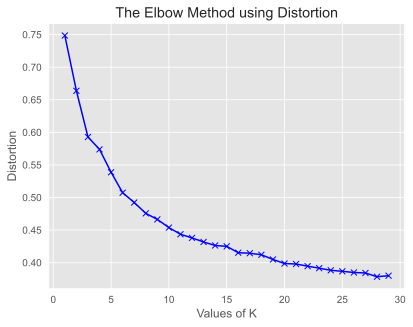

In [231]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

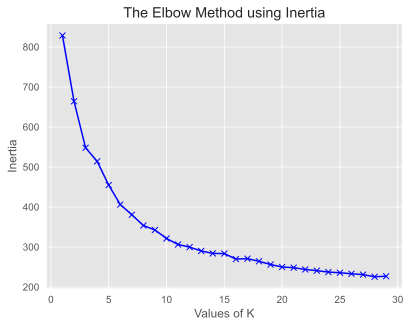

In [232]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [294]:
kmeans = KMeans(n_clusters=6)
y_km = kmeans.fit_predict(pca_X)
y_km = pd.DataFrame(y_km)
y_km

,0
0,5
1,1
2,0
3,5
4,1
...,...
1449,0
1450,3
1451,5
1452,0


In [295]:
dbscan = DBSCAN(eps=0.43, min_samples=15, metric='euclidean')
y_db = dbscan.fit(pca_X)
print(y_db.labels_)
y_db=pd.DataFrame(y_db.labels_)
y_db

[ 5  0  1 ... -1  1  1]


,0
0,5
1,0
2,1
3,-1
4,-1
...,...
1449,1
1450,0
1451,-1
1452,1


In [296]:
X_embedded = TSNE(n_components=2).fit_transform(vectorized_X)
X_embedded

array([[ 11.6636915, -28.969645 ],
       [ -4.406813 ,  22.754492 ],
       [ 29.918076 ,  12.356622 ],
       ...,
       [ 25.344194 , -23.680662 ],
       [ 40.138718 ,  10.730099 ],
       [ 38.187798 ,  -5.9963384]], dtype=float32)

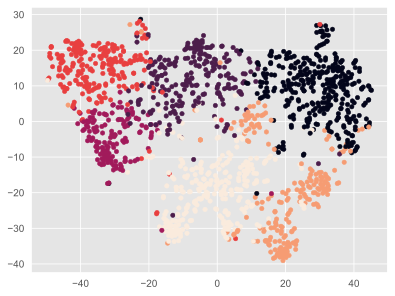

In [297]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_km, s=20)

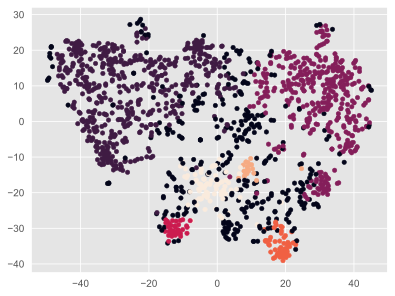

In [298]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_db, s=20)

In [299]:
from sklearn.metrics import silhouette_score

print(silhouette_score(pca_X, kmeans.fit_predict(pca_X)))

0.25178118340760375


In [300]:
print(silhouette_score(pca_X, dbscan.fit_predict(pca_X)))

0.1486756350051669


In [301]:
clustered_vectorized_X = copy.deepcopy(vectorized_X)
clustered_vectorized_X["cluster"] = y_km
clustered_vectorized_X = clustered_vectorized_X.sort_values("cluster")
clustered_vectorized_X.reset_index(inplace=True)
clustered_vectorized_X.drop("index", axis=1, inplace=True)
clustered_vectorized_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cluster
0,0.721036,0.000000,0.043112,0.000000,0.039910,0.000000,0.021421,0.261586,0.612985,0.000000,0.098746,0.019790,0.061889,0.000000,0.000000,0.134337,0
1,0.152842,0.253860,0.467898,0.000000,0.054144,0.107393,0.203421,0.029573,0.759291,0.080725,0.107171,0.080545,0.111949,0.051097,0.142795,0.000000,0
2,0.084474,0.314970,0.150081,0.000000,0.181684,0.052995,0.183556,0.000000,0.813606,0.015934,0.148079,0.307372,0.011049,0.151288,0.000000,0.000000,0
3,0.065381,0.058175,0.078184,0.000000,0.130279,0.071780,0.077693,0.000000,0.947329,0.086328,0.014326,0.057424,0.164615,0.150269,0.000000,0.000000,0
4,0.109223,0.129579,0.243808,0.039217,0.177337,0.079942,0.086528,0.228945,0.602886,0.048072,0.207418,0.255814,0.033333,0.380356,0.063777,0.434123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.030335,0.179944,0.000000,0.196053,0.376111,0.000000,0.173029,0.000000,0.000000,0.040054,0.345644,0.106573,0.055547,0.785947,0.000000,0.060286,5
1450,0.051968,0.000000,0.082859,0.037318,0.168753,0.152144,0.197615,0.184346,0.000000,0.000000,0.075915,0.639006,0.412358,0.246122,0.060690,0.464747,5
1451,0.135846,0.000000,0.000000,0.182909,0.120307,0.328112,0.064572,0.000000,0.000000,0.000000,0.089300,0.029828,0.621877,0.652835,0.000000,0.000000,5
1452,0.225439,0.000000,0.022311,0.000000,0.041307,0.061449,0.044341,0.000000,0.000000,0.000000,0.286169,0.068277,0.882551,0.272878,0.036314,0.000000,5


# Topic Extraction

In [302]:
clustered_vectorized_X["cluster"].unique()


array([0, 1, 2, 3, 4, 5])

In [303]:
lda = LatentDirichletAllocation(n_components=1, random_state=0)
for i in clustered_vectorized_X["cluster"].unique():
    cluster_i = copy.deepcopy(clustered_vectorized_X[clustered_vectorized_X["cluster"] == i])
    cluster_i.drop("cluster", axis=1, inplace=True)
    lda.fit(cluster_i)
    feature_names = vectorizer.get_feature_names_out()
    topic_names = []
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic of Cluster #{i + 1}:")
        top_feature_indices = topic.argsort()[-5:]
        # print(top_feature_indices)
        top_features = [feature_names[i] for i in top_feature_indices]
        print(" ".join(top_features)+" \n")
        # Optionally, create a topic name based on the top features
        topic_name = "Topic #" + str(topic_idx) + ": " + " ".join(top_features[:3])
        topic_names.append(topic_name)

Topic of Cluster #1:
case use study infection patient 

Topic of Cluster #2:
cell infection use viral virus 

Topic of Cluster #3:
viral virus use cell protein 

Topic of Cluster #4:
infection virus use protein cell 

Topic of Cluster #5:
time use infection case disease 

Topic of Cluster #6:
high result group study use 



In [304]:
nmf = NMF(n_components=1, random_state=0)
for i in clustered_vectorized_X["cluster"].unique():
    cluster_i = copy.deepcopy(clustered_vectorized_X[clustered_vectorized_X["cluster"] == i])
    cluster_i.drop("cluster", axis=1, inplace=True)
    nmf.fit(cluster_i)
    nmf_topic_names=[]
    for topic_idx, topic in enumerate(nmf.components_):
        print(f"Topic of Cluster #{i + 1}:")
        top_feature_indices = topic.argsort()[-5:]
        # print(top_feature_indices)
        top_features = [feature_names[i] for i in top_feature_indices]
        print(" ".join(top_features)+" \n")
        # Optionally, create a topic name based on the top features
        topic_name = "Topic #" + str(topic_idx) + ": " + " ".join(top_features[:3])
        nmf_topic_names.append(topic_name)

Topic of Cluster #1:
case study use infection patient 

Topic of Cluster #2:
cell infection use viral virus 

Topic of Cluster #3:
viral virus use cell protein 

Topic of Cluster #4:
infection virus use protein cell 

Topic of Cluster #5:
time use infection case disease 

Topic of Cluster #6:
high result group study use 



C:\Users\arian\PycharmProjects\TextMining\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\arian\PycharmProjects\TextMining\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\arian\PycharmProjects\TextMining\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\arian\PycharmProjects\TextMining\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\arian\PycharmProjects\TextMining\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number 